IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from scipy.stats import pearsonr

In [ ]:
# Define companies
large_cap_software = ['AAPL', 'MSFT']
mid_cap_software = ['RNG', 'OLED']
large_cap_ecommerce = ['AMZN', 'EBAY']
mid_cap_ecommerce = ['W', 'ETSY']

all_stocks = large_cap_software + mid_cap_software + large_cap_ecommerce + mid_cap_ecommerce

data = yf.download(all_stocks, start="2015-01-01", end="2024-12-31",auto_adjust=False)
prices = data['Adj Close']

returns = prices.pct_change().dropna()

fed_funds = pd.read_csv('FEDFUNDS.csv', parse_dates=['observation_date']).set_index('observation_date')
inflation = pd.read_csv('CPIAUCSL.csv', parse_dates=['observation_date']).set_index('observation_date')
treasury = pd.read_csv('GS10.csv', parse_dates=['observation_date']).set_index('observation_date')

fed_funds = fed_funds.resample('D').ffill()
inflation = inflation.resample('D').ffill()
treasury = treasury.resample('D').ffill()

def interest_rate_sensitivity(stock_returns, interest_rate_changes, stock_name):
    df = pd.concat([stock_returns, interest_rate_changes], axis=1).dropna()
    X = sm.add_constant(df.iloc[:,1])  # interest rate change
    y = df.iloc[:,0]                  # stock return
    model = sm.OLS(y, X).fit()
    print(f"\n=== {stock_name} Interest Rate Sensitivity ===")
    print(model.summary())

#fed_changes = fed_funds['FEDFUNDS'].diff()
treasury_changes = treasury['GS10'].diff()

interest_rate_sensitivity(returns['AAPL'], treasury_changes, 'AAPL')
interest_rate_sensitivity(returns['MSFT'], treasury_changes, 'MSFT')
interest_rate_sensitivity(returns['RNG'], treasury_changes, 'RNG')
interest_rate_sensitivity(returns['OLED'], treasury_changes, 'OLED')
interest_rate_sensitivity(returns['AMZN'], treasury_changes, 'AMZN')
interest_rate_sensitivity(returns['EBAY'], treasury_changes, 'EBAY')
interest_rate_sensitivity(returns['W'], treasury_changes, 'W')
interest_rate_sensitivity(returns['ETSY'], treasury_changes, 'ETSY')


         Alpha  Beta (Rate Sensitivity)   p-value  R-squared
AAPL  0.001022                 2.979137  0.000009   0.008078
AMZN  0.001166                 1.093231  0.153191   0.000840
EBAY  0.000583                 0.534193  0.449986   0.000235
ETSY  0.001073                -2.433421  0.079354   0.001267
MSFT  0.001068                 2.518083  0.000072   0.006470
OLED  0.000884                 3.023423  0.007198   0.002970
RNG   0.000868                -1.693830  0.179880   0.000740
W     0.001277                -3.902716  0.025455   0.002054


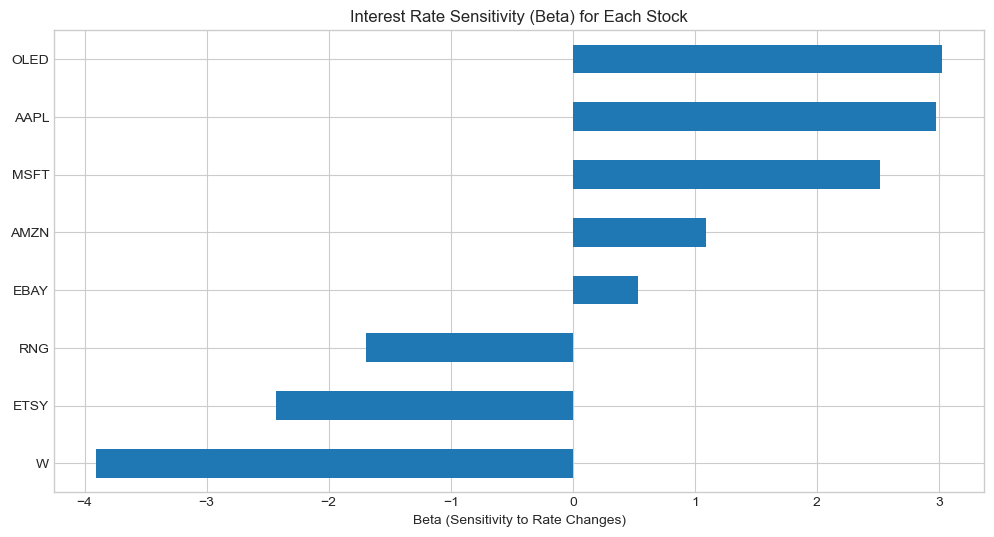

In [66]:
software_large = ['AAPL', 'MSFT']
software_mid = ['RNG','OLED']
ecommerce_large = ['AMZN', 'EBAY']
ecommerce_mid = ['W', 'ETSY']
all_stocks = software_large + software_mid + ecommerce_large + ecommerce_mid
daily_returns = prices.pct_change().dropna()

# Download adjusted close prices (auto-adjust = True)
prices = yf.download(all_stocks, start="2015-05-01", end="2024-12-31", auto_adjust= True, progress=False)['Close']

# Download full data separately to get Volume
data_full = yf.download(all_stocks, start="2015-01-01", end="2024-12-31", progress=False)
volumes = data_full['Volume']

# -------------------------
# Step 1: Download Interest Rate Data (10-Year Treasury Yield)
# -------------------------
rate_data = yf.download('^TNX', start="2015-01-01", end="2024-12-31", interval='1d', progress=False)['Close']
rate_data = rate_data / 100  # Convert basis points to percentage
rate_changes = rate_data.diff().dropna()

# -------------------------
# Step 2: Align Daily Returns with Rate Changes
# -------------------------
# (Assume you already have `daily_returns` dataframe from your previous steps)

rate_sensitivity_results = {}

for stock in daily_returns.columns:
    # Align stock returns and rate changes
    aligned = pd.concat([daily_returns[stock], rate_changes], axis=1).dropna()
    aligned.columns = ['Stock_Return', 'Rate_Change']
    
    if len(aligned) > 0:  # Avoid empty regressions
        X = sm.add_constant(aligned['Rate_Change'])
        y = aligned['Stock_Return']
        model = sm.OLS(y, X).fit()
        
        rate_sensitivity_results[stock] = {
            'Alpha': model.params['const'],
            'Beta (Rate Sensitivity)': model.params['Rate_Change'],
            'p-value': model.pvalues['Rate_Change'],
            'R-squared': model.rsquared
        }

# Create a results dataframe
rate_sensitivity_df = pd.DataFrame(rate_sensitivity_results).T
print(rate_sensitivity_df)

# -------------------------
# Step 3: (Optional) Visualize the Betas
# -------------------------
plt.figure(figsize=(12,6))
rate_sensitivity_df['Beta (Rate Sensitivity)'].sort_values().plot(kind='barh')
plt.title('Interest Rate Sensitivity (Beta) for Each Stock')
plt.xlabel('Beta (Sensitivity to Rate Changes)')
plt.grid(True)
plt.show()

1. Positive Sensitivity:
OLED (Beta = 3.02), AAPL (Beta = 2.98), and MSFT (Beta = 2.52)

All have strong positive Beta values, meaning when interest rates rise, these stocks tend to rise as well (unexpected for tech, but plausible at daily level).

Statistical significance confirmed by very small p-values (< 0.01).

R-squared is still low (around 0.6%–0.8%), so while significant, rate changes only explain a small part of the daily moves.

2. Negative Sensitivity:
Wayfair (W) (Beta = -3.90) and Etsy (ETSY) (Beta = -2.43)

Both have large negative Betas.

Wayfair’s p-value (0.025) suggests a statistically significant negative reaction to rate increases.

Etsy’s p-value (0.079) suggests marginal significance (weaker, but still notable at 10% level).

Interpretation:

As rates rise, consumer spending weakens → these ecommerce stocks decline.

Smaller consumer discretionary businesses are more vulnerable to borrowing costs and tighter consumer budgets.

3. Neutral / No Clear Sensitivity:
Amazon (AMZN) and eBay (EBAY)

Betas are positive but small.

p-values are high (0.15 for AMZN, 0.45 for EBAY) → not statistically significant.

Meaning: daily Treasury rate changes do not meaningfully impact these larger ecommerce companies.

RNG

Beta = -1.69, but very high p-value (0.179) → not statistically significant.